In [15]:
import numpy as np
import matplotlib.pyplot as plt
import spikes4 as spk4
import snn_models

import scipy.io as sio #allows for importing of .mat files 

In [16]:
#%% parameters
time_step = 1 # 1ms time resolution

lr = 0.002 # learning rate 0.005
thr = 1 #0.6 # v threshold
tau_out = 3 # output decay time constant /// unit: ms
kappa = np.exp(-time_step/tau_out) # output decay
tau_mem = 20 # v decay time constant /// unit: ms
alpha = np.exp(-time_step/tau_mem) # v decay
beta = 0.2 # adaptation increment 
tau_a = 200 # adaptation decay time constant /// unit: ms
rho = np.exp(-time_step/(tau_a+1e-12)) # adaptation decay
t_ref = 2 # refractory period /// unit: ms
c_reg = 50
f_target = 10*(1e-3) # 10 Hz = 10*(1e-3) 1/ms
params = np.array([lr, thr, alpha, beta, kappa, rho, t_ref, c_reg,f_target]) # save as a vector

In [17]:
with open('spike_data95.npy','rb') as f:
    spike_data = np.load(f)
with open('interpolated_y95.npy','rb') as g:
    interpolated_y = np.load(g)

In [18]:
# divide data in batches
nb_batch = 10 # number of batches
nb_inputs, nb_hidden, nb_outputs  = 95, 100, 4  # set nb_outputs to 4 just for this part

nb_tstep = int(spike_data.shape[0]/10)
x2 = np.zeros((nb_batch, nb_tstep, nb_inputs))
y2 = np.zeros((nb_batch, nb_tstep, nb_outputs))
for b in range(nb_batch):
    if b == 0:
        x2[b,:,:] = spike_data[0:nb_tstep,:]
        y2[b,:,:] = interpolated_y[0:nb_tstep,:]
    else:
        x2[b,:,:] = spike_data[nb_tstep*b:nb_tstep*(b+1),:]
        y2[b,:,:] = interpolated_y[nb_tstep*b:nb_tstep*(b+1),:]

# normalization
y2 = y2/ np.max(np.abs(y2))

In [19]:
# 1 output case
nb_inputs, nb_hidden, nb_outputs = 95, 100, 1
y2 = y2[:,:,0:1]

In [20]:
#%% initialize weight
weight_scale = 10*(1.0-alpha) #!!!
w1 = np.random.normal(size=(nb_inputs,nb_hidden), loc=0.0, scale=weight_scale/np.sqrt(nb_inputs)) # input-->hidden
w2 = np.random.normal(size=(nb_hidden,nb_outputs), loc=0.0, scale=weight_scale/np.sqrt(nb_hidden)) # hidden-->hidden
#bias = np.random.normal(size=(nb_outputs), loc=0.0, scale=weight_scale/np.sqrt(nb_outputs)) # output bias
bias = np.zeros(nb_outputs) # output bias
B = np.random.normal(size=(nb_outputs,nb_hidden), loc=0.0, scale=weight_scale/np.sqrt(nb_outputs)) #!!! random e-prop

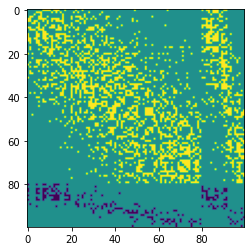

In [21]:
#%% recurrent weights (choose only one)
############### (1) random network ###############
# wr = np.random.normal(size=(nb_hidden,nb_hidden), loc=0.0, scale=weight_scale/np.sqrt(nb_hidden)) # hidden-->output
# np.fill_diagonal(wr,0) # no self connectivity

############### (2) E/I network ###############
import graph_analysis
nb_e = int(nb_hidden*0.8)
nb_i = nb_hidden - nb_e
ind_fromi = np.zeros((nb_hidden,nb_hidden),dtype=bool)
ind_fromi[nb_e:,:] = True # index of inhibitory neurons

wr, xy, cdens = graph_analysis.aij_distance2d([1000,1000], [250,150], nb_e, nb_i, np.array([[1,-1],[1,-1]]), cself=False, plot=False, randomseed=None)
wr = wr.T
wr *= 0.05 # scaling

plt.imshow(wr) # visualize initial weights

In [22]:
# run it with smaller data set (here reduce the number of timestep)
# 1 output case
x = x2[:,0:int(31413*5),:]
y = y2[:,0:int(31413*5),0:1]

# 4 output case
#x2 = x2[:,0:int(31413*5),:]
#y2 = y2[:,0:int(31413*5),:]

In [23]:
#%% run train
nb_inputs, nb_hidden, nb_outputs  = 95, 100, 1

dw1_past = np.zeros((nb_inputs,nb_hidden))
dw2_past = np.zeros((nb_hidden,nb_outputs))
dwr_past = np.zeros((nb_hidden,nb_hidden))
dbias_past = np.zeros((nb_outputs,))
loss_train, fr_train, acc_train, spktr, wrs, atr = [],[],[],[],[],[]
loss_valid, fr_valid, acc_valid = [],[],[]
n_epochs = 2

for epoch in range(n_epochs): # 100
    ######################### train #########################
    batch_idx = 0
    x_train, y_train = x2[batch_idx,:,:].copy(),y2[batch_idx,:,0:1].copy()
    loss_batch, out_rec, dw1, dwr, dw2, dbias, v_rec, z_rec, a_rec = snn_models.lif_eprop5(w1,wr,w2,bias,B,x_train,y_train,params)
    
    dw1_past = 0.9*dw1_past + dw1[0] #!!! momentum=0.9
    dw2_past = 0.9*dw2_past + dw2[0] #!!! momentum=0.9
    dwr_past = 0.9*dwr_past + dwr[0] #!!! momentum=0.9
    dbias_past = 0.9*dbias_past + dbias[0] #!!! momentum=0.9
        
    w1 += dw1_past # input-->hidden update
    w2 += dw2_past # hidden-->hidden update
    wr += dwr_past # hidden-->output update
    bias += dbias_past # bias update 
        
    print("loss_batch=", loss_batch)
        # w1 += np.mean(dw1,0) # these are for no-momentum update (slow learning)
        # w2 += np.mean(dw2,0)
        # wr += np.mean(dwr,0)
        # bias += np.mean(dbias,0)
        # np.fill_diagonal(wr,0) # no-self connectivity

        #!!! below 5 lines are valid only for E/I network (uncomment when using random network) 
    ind_negative = wr<0
    ind = ind_negative*(~ind_fromi) # find negative & exciatory neurons
    wr[ind] = 0. # force the negative weights to 0
    ind = (~ind_negative)*ind_fromi # find positive & inhibitory neurons
    wr[ind] = 0. # force the positive weights to 0
        
    loss_train.append(loss_batch.mean()) # save loss 
    fr_train.append(1000*z_rec.mean()) # save firing rate
    print('EPOCH %d TRAIN) loss: %0.4f, fr: %0.4f Hz' %(epoch, loss_train[epoch], fr_train[epoch]))

    ######################### validate #########################
#    x_valid,y_valid = x[8:].copy(),y[8:].copy() # 20% of data for validation
#    loss_batch, out_rec, dw1, dwr, dw2, dbias, v_rec, z_rec, a_rec = snn_models.lif_eprop2(w1,wr,w2,bias,B,x_valid,y_valid,decays)
    
#    loss_valid.append(loss_batch.mean()) # save loss
#    fr_valid.append(1000*z_rec.mean()) # save firing rate
#    print('EPOCH %d VALID) loss: %0.4f, fr: %0.4f Hz' %(epoch, loss_valid[epoch], fr_valid[epoch]))
        
#    spktr.append(z_rec[0]) # save spike train /// save one batch data only to save memory
#    atr.append(a_rec[0]) # save a trace
#    wrs.append(wr.copy()) # save weights
    
    ######################### save best weights #########################
#    if loss_valid[-1] == min(loss_valid): # or you can use acc criteria instead
#        w1_save,w2_save,wr_save,bias_save = w1.copy(),w2.copy(),wr.copy(),bias.copy()
#        epoch_best = epoch
#spktr = np.stack(spktr,0)
#atr = np.stack(atr,0)
#wrs = np.stack(wrs,0)
#N = int(n_epochs/8) # epoch interval for plotting

loss_batch= [225.63563363]
EPOCH 0 TRAIN) loss: 225.6356, fr: 0.0746 Hz
loss_batch= [80149162.92344575]
EPOCH 1 TRAIN) loss: 80149162.9234, fr: 3.3916 Hz


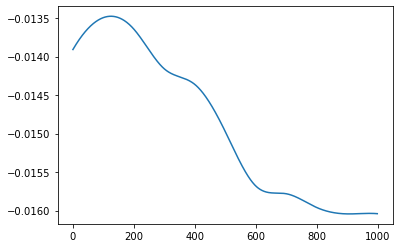

In [13]:
plt.plot(y2[0,1:1000,0])

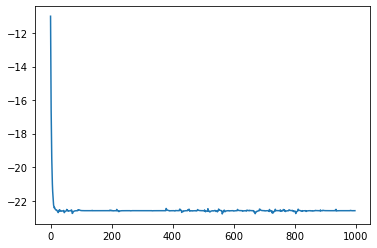

In [26]:
plt.plot(out_rec[0,1:1000,0])